# 04 — Affordability Analysis

**Goal:** Track a proxy for housing affordability and compare **Bulgaria** to the **EU**.

We use the **HPI-to-earnings ratio** as a simple proxy:
$$
\text{afford\_ratio} = \frac{\text{House Price Index}}{\text{Net earnings (EUR)}}
$$
and its real-income variant (divide by **real earnings**).

Because HPI is an index and earnings are in euros, the ratio is only meaningful **relatively over time** within a country.  
So we also build a **ratio index** (country-specific base = 100 at the first available year):
$$
\text{afford\_ratio\_index} = 100 \times \frac{\text{afford\_ratio}_t}{\text{afford\_ratio}_{t_0}}
$$

**This notebook:**
1) Construct affordability ratios (+ real-income version)  
2) Plot **Bulgaria vs EU average** of the ratio index  
3) Measure divergence (2015→2024 change)  
4) **Cluster countries** by their ratio-index trajectories (is Bulgaria with Eastern or Western patterns?)  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import Dict, List, Tuple

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

PROC = Path("../data/processed")
FIGS = Path("../reports/figures")

PROC, FIGS

EU27 = {
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czechia","Denmark","Estonia","Finland",
    "France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg",
    "Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"
}


## 1) Load merged panel and build affordability ratios
- `afford_ratio` = HPI / net_earnings  
- `afford_ratio_real` = HPI / real_earnings  
- Country-specific **index (base=100 at first year)** for both ratios


In [2]:
def make_affordability_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create affordability ratio columns (levels and base-100 indices).

    Parameters
    ----------
    df : pd.DataFrame
        Must contain: 'country', 'year', 'house_price_index',
        'net_earnings', and 'real_earnings'.

    Returns
    -------
    pd.DataFrame
        Original columns plus:
        - 'afford_ratio'        = HPI / net_earnings
        - 'afford_ratio_real'   = HPI / real_earnings
        - 'afford_ratio_index'  = 100 * afford_ratio / afford_ratio[first_year_in_country]
        - 'afford_ratio_real_index' = 100 * afford_ratio_real / afford_ratio_real[first_year]
    """
    out = df.copy()
    out["afford_ratio"] = out["house_price_index"] / out["net_earnings"]
    out["afford_ratio_real"] = out["house_price_index"] / out["real_earnings"]

    def base100(s: pd.Series) -> pd.Series:
        base = s.iloc[0]
        return (s / base) * 100.0

    out["afford_ratio_index"] = (
        out.sort_values(["country","year"])
           .groupby("country", group_keys=False)["afford_ratio"]
           .apply(base100)
    )
    out["afford_ratio_real_index"] = (
        out.sort_values(["country","year"])
           .groupby("country", group_keys=False)["afford_ratio_real"]
           .apply(base100)
    )
    return out


panel = pd.read_csv(PROC / "merged_panel.csv").sort_values(["country","year"])
panel = make_affordability_columns(panel)
panel.head(20)


,country,year,house_price_index,net_earnings,unemployment_rate,hicp_index,gdp_per_capita,real_earnings,afford_ratio,afford_ratio_real,afford_ratio_index,afford_ratio_real_index
0,Austria,2015,128.63,34414.48,6.1,100.00,39640.0,34414.480000,0.003738,0.003738,100.000000,100.000000
1,Austria,2016,136.27,36707.82,6.5,100.97,40690.0,36355.174804,0.003712,0.003748,99.320890,100.284303
2,Austria,2017,144.48,37220.14,5.9,103.22,41760.0,36059.038946,0.003882,0.004007,103.855302,107.199443
3,Austria,2018,153.57,37847.53,5.2,105.41,43360.0,35905.065933,0.004058,0.004277,108.559488,114.432556
4,Austria,2019,162.82,41162.12,4.8,106.98,44570.0,38476.462890,0.003956,0.004232,105.830039,113.216976
5,Austria,2020,175.30,42589.37,6.0,108.47,42650.0,39263.731907,0.004116,0.004465,110.123408,119.450860
6,Austria,2021,198.25,42549.21,6.2,111.46,45380.0,38174.421317,0.004659,0.005193,124.658138,138.943961
7,Austria,2022,221.28,47272.61,4.8,121.07,49490.0,39045.684315,0.004681,0.005667,125.236674,151.624041
8,Austria,2023,212.27,48897.51,5.1,130.40,51830.0,37498.090491,0.004341,0.005661,116.145080,151.453184
9,Austria,2024,208.89,52978.41,5.2,134.21,52760.0,39474.264213,0.003943,0.005292,105.491550,141.580209


## 2) EU averages and Bulgaria series

We compute **EU27 mean** (simple country average per year) and extract **Bulgaria**.


In [3]:
def eu_average_series(
    df: pd.DataFrame,
    include_set: set,
    value_col: str
) -> pd.DataFrame:
    """
    Compute a simple (unweighted) EU average per-year for a column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'country', 'year', and `value_col`.
    include_set : set
        Set of country names to include (e.g., EU27).
    value_col : str
        Column to average (e.g., 'afford_ratio_index').

    Returns
    -------
    pd.DataFrame
        Columns: 'year', f'eu_{value_col}_mean'
    """
    tmp = df[df["country"].isin(include_set)]
    ser = (
        tmp.groupby("year")[value_col]
           .mean()
           .rename(f"eu_{value_col}_mean")
           .reset_index()
    )
    return ser


eu_aff = eu_average_series(panel, EU27, "afford_ratio_index")
bg_aff = panel.loc[panel["country"]=="Bulgaria", ["year", "afford_ratio_index"]].rename(
    columns={"afford_ratio_index":"bg_aff_index"}
)

eu_aff.head(10), bg_aff.head(10)


(   year  eu_afford_ratio_index_mean
 0  2015                  100.000000
 1  2016                  101.547941
 2  2017                  104.129548
 3  2018                  106.176971
 4  2019                  107.739973
 5  2020                  110.713662
 6  2021                  116.832664
 7  2022                  121.122439
 8  2023                  112.999099
 9  2024                  112.298119,
     year  bg_aff_index
 20  2015    100.000000
 21  2016     99.746219
 22  2017    100.885000
 23  2018    101.795698
 24  2019     96.340358
 25  2020     94.714935
 26  2021     87.778403
 27  2022     88.556192
 28  2023     86.050348
 29  2024     88.963497)

## 3) Plot Bulgaria vs EU — affordability ratio index (base=100)

> If Bulgaria's line rises faster than EU, affordability **worsens** faster in Bulgaria (higher HPI per euro earned).


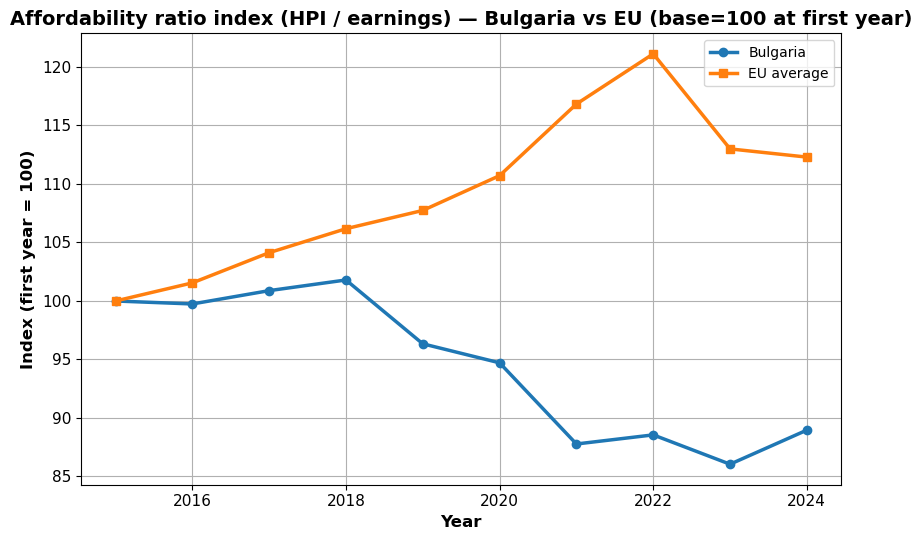

In [4]:
def plot_country_vs_eu(
    country_df: pd.DataFrame,
    eu_df: pd.DataFrame,
    country_col: str,
    eu_col: str,
    title: str,
    ylabel: str,
    outname: str
) -> None:
    """
    Plot a country series vs the EU mean series.

    Parameters
    ----------
    country_df : pd.DataFrame
        Columns: 'year', `country_col`
    eu_df : pd.DataFrame
        Columns: 'year', `eu_col`
    country_col : str
        Country value column name (e.g., 'bg_aff_index')
    eu_col : str
        EU value column name (e.g., 'eu_afford_ratio_index_mean')
    title : str
        Plot title
    ylabel : str
        Y-axis label
    outname : str
        File name for PNG under reports/figures/

    Returns
    -------
    None
    """
    d = country_df.merge(eu_df, on="year", how="inner").sort_values("year")
    fig, ax = plt.subplots(figsize=(8.5,5.5))
    ax.plot(d["year"], d[country_col], marker="o", linewidth=2.5, label="Bulgaria")
    ax.plot(d["year"], d[eu_col], marker="s", linewidth=2.5, label="EU average")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Year", fontsize=12, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
    ax.tick_params(labelsize=11)
    ax.legend()
    plt.tight_layout()
    plt.savefig(FIGS / outname, dpi=160)
    plt.show()


plot_country_vs_eu(
    country_df=bg_aff,
    eu_df=eu_aff,
    country_col="bg_aff_index",
    eu_col="eu_afford_ratio_index_mean",
    title="Affordability ratio index (HPI / earnings) — Bulgaria vs EU (base=100 at first year)",
    ylabel="Index (first year = 100)",
    outname="bg_vs_eu_afford_ratio_index.png"
)


## 4) Quantify divergence (2015→2024 change)

We compare the **change in the ratio index** for Bulgaria vs EU.  
Positive values = **worsening affordability** (HPI rising faster than earnings).


In [5]:
def change_between(
    df: pd.DataFrame, value_col: str, start: int, end: int
) -> float:
    """
    Compute change of `value_col` between two years.

    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: 'year', `value_col`.
    value_col : str
        Column to compare (e.g., 'bg_aff_index').
    start : int
        Start year (inclusive).
    end : int
        End year (inclusive).

    Returns
    -------
    float
        value[end] - value[start]
    """
    d = df.set_index("year")[value_col]
    if start not in d.index or end not in d.index:
        return float("nan")
    return float(d.loc[end] - d.loc[start])


merged = bg_aff.merge(eu_aff, on="year", how="inner")

bg_change = change_between(merged.rename(columns={"bg_aff_index":"val"}), "val", 2015, 2024)
eu_change = change_between(merged.rename(columns={"eu_afford_ratio_index_mean":"val"}), "val", 2015, 2024)

bg_change, eu_change


(-11.036503239090763, 12.298118982321213)

**Interpretation:**
- If `bg_change > eu_change` → Bulgaria’s affordability worsened **faster** than EU average.  
- If `bg_change < eu_change` → Bulgaria improved **relative** to EU.


## 5) Cluster countries by affordability ratio index

We cluster countries by their **time-series shape** of `afford_ratio_index` (2015–2024).
Steps:
1) Build a country × year matrix
2) Fill short gaps by linear interpolation (within country)
3) **Z-score per country** (remove level) to focus on **trajectory**
4) KMeans (k=3 by default), label each country
5) Plot cluster averages; highlight **Bulgaria**


In [13]:
from sklearn.cluster import KMeans

YEARS = list(range(2015, 2025))

def make_ratio_matrix(df: pd.DataFrame, value_col: str, years: List[int]) -> pd.DataFrame:
    """
    Create a pivot matrix of value_col with countries as rows and years as columns.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'country', 'year', and value_col.
    value_col : str
        Column to pivot (e.g., 'afford_ratio_index').
    years : List[int]
        Ordered list of year columns to include.

    Returns
    -------
    pd.DataFrame
        Index = country, columns = years. Missing values are linearly interpolated
        within each country, then forward/back-filled if needed.
    """
    p = (
        df.pivot(index="country", columns="year", values=value_col)
          .reindex(columns=years)
          .sort_index()
    )
    p = p.apply(lambda s: s.interpolate(axis=0, limit_direction="both"), axis=1)
    p = p.ffill(axis=1).bfill(axis=1)
    return p


ratio_mat = make_ratio_matrix(panel, "afford_ratio_index", YEARS)
ratio_mat.head(20)


year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
country,,,,,,,,,,
Austria,100.0,99.320890,103.855302,108.559488,105.830039,110.123408,124.658138,125.236674,116.145080,105.491550
Belgium,100.0,99.862797,101.015805,101.167794,101.434241,104.338679,109.327914,109.644737,103.999169,103.060527
Bulgaria,100.0,99.746219,100.885000,101.795698,96.340358,94.714935,87.778403,88.556192,86.050348,88.963497
Croatia,100.0,99.709424,100.402698,101.862122,107.558660,112.641583,116.355008,122.235116,121.056747,127.186543
Cyprus,100.0,100.000000,100.000000,97.942263,97.673864,98.823013,97.522755,92.654918,88.852152,86.665030
Czechia,100.0,99.836964,102.701522,100.103885,103.932388,113.097958,116.692352,122.527231,110.017408,126.196890
Denmark,100.0,103.590873,107.162301,106.010663,106.372745,109.005512,121.872734,123.876160,114.827959,114.323573
Estonia,100.0,96.785245,96.747737,92.099530,93.189206,94.831391,105.664060,124.239292,113.248012,120.273398
Finland,100.0,99.922996,99.127332,98.128331,96.167139,94.581021,96.756949,93.658658,84.268789,80.226342


In [7]:
def kmeans_cluster_timecurves(
    matrix: pd.DataFrame,
    k: int = 3,
    random_state: int = 42
) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Run KMeans on **z-scored per-country** time series.

    Parameters
    ----------
    matrix : pd.DataFrame
        Country × Year matrix of the series (e.g., afford_ratio_index).
    k : int, default 3
        Number of clusters.
    random_state : int, default 42
        Random seed for reproducibility.

    Returns
    -------
    Tuple[pd.Series, pd.DataFrame]
        - labels : pd.Series mapping country -> cluster_id
        - centers : pd.DataFrame with cluster centers (in z-scored space)
    """
    Z = matrix.copy()
    Z = Z.sub(Z.mean(axis=1), axis=0).div(Z.std(axis=1).replace(0, np.nan), axis=0)
    Z = Z.fillna(0.0)

    km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    km.fit(Z.values)

    labels = pd.Series(km.labels_, index=Z.index, name="cluster")
    centers = pd.DataFrame(km.cluster_centers_, columns=Z.columns)
    return labels, centers


labels, centers = kmeans_cluster_timecurves(ratio_mat, k=3, random_state=42)
labels.sort_values().head(10), centers


c:\Users\WALL-E\anaconda3\envs\europe-housing-trends\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(country
 Austria       0
 Belgium       0
 Germany       0
 France        0
 Poland        0
 Slovakia      0
 Luxembourg    0
 Italy         1
 Lithuania     1
 Latvia        1
 Name: cluster, dtype: int32,
 year      2015      2016      2017      2018      2019      2020      2021  \
 0    -0.763615 -0.891781 -0.757050 -0.458250 -0.176445  0.477274  1.434261   
 1     0.741882  0.835754  0.875900  0.685239  0.310768 -0.150033 -0.188979   
 2    -1.318756 -1.058913 -0.705895 -0.519253 -0.355152  0.028920  0.618963   
 
 year      2022      2023      2024  
 0     1.469911  0.181304 -0.515608  
 1    -0.339269 -1.232295 -1.538968  
 2     1.238603  0.921802  1.149680  )

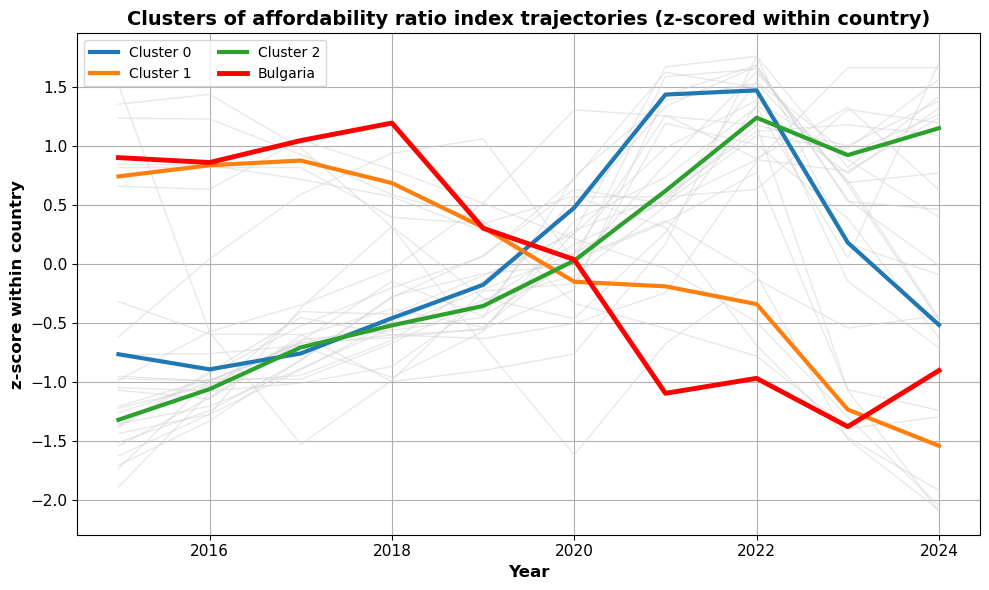

country
Bulgaria    1
Name: cluster, dtype: int32

In [8]:
def plot_clusters_with_country(
    matrix: pd.DataFrame,
    labels: pd.Series,
    centers: pd.DataFrame,
    country_to_highlight: str,
    title: str,
    outname: str
) -> None:
    """
    Plot cluster centers and all member trajectories (light), highlight one country.

    Parameters
    ----------
    matrix : pd.DataFrame
        Country × Year matrix (levels, not z-scored).
    labels : pd.Series
        Country -> cluster_id.
    centers : pd.DataFrame
        Cluster centers in z-scored space (same columns as matrix).
    country_to_highlight : str
        Country name to emphasize (e.g., 'Bulgaria').
    title : str
        Plot title.
    outname : str
        PNG filename under reports/figures/.

    Returns
    -------
    None
    """
    Z = matrix.copy()
    Z = Z.sub(Z.mean(axis=1), axis=0).div(Z.std(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    fig, ax = plt.subplots(figsize=(10,6))
    years = Z.columns.astype(int)

    for c_id in sorted(labels.unique()):
        members = labels[labels == c_id].index
        ax.plot(years, Z.loc[members].T, color="lightgray", alpha=0.5, linewidth=1)

    for c_id in range(centers.shape[0]):
        ax.plot(years, centers.iloc[c_id].values, linewidth=3, label=f"Cluster {c_id}")

    if country_to_highlight in Z.index:
        ax.plot(years, Z.loc[country_to_highlight].values, linewidth=3.5, color="red", label=country_to_highlight)

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Year", fontsize=12, fontweight="bold")
    ax.set_ylabel("z-score within country", fontsize=12, fontweight="bold")
    ax.tick_params(labelsize=11)
    ax.legend(loc="upper left", ncol=2)
    plt.tight_layout()
    plt.savefig(FIGS / outname, dpi=160)
    plt.show()


plot_clusters_with_country(
    matrix=ratio_mat,
    labels=labels,
    centers=centers,
    country_to_highlight="Bulgaria",
    title="Clusters of affordability ratio index trajectories (z-scored within country)",
    outname="clusters_afford_ratio_index.png"
)

labels.loc[["Bulgaria"]]


## 6) Regional averages (Eastern vs Western vs Balkans)

We now compare affordability ratio index by geographic grouping.


In [9]:
EASTERN = {
    "Bulgaria","Romania","Poland","Hungary","Czechia","Slovakia",
    "Lithuania","Latvia","Estonia","Croatia","Slovenia"
}

WESTERN = {
    "Austria","Belgium","France","Germany","Netherlands","Luxembourg",
    "Ireland","Italy","Spain","Portugal","Denmark","Sweden","Finland","Norway"
}

BALKANS = {"Bulgaria","Romania","Croatia","Slovenia","Greece"}

def assign_region(country: str) -> str:
    if country in BALKANS:
        return "Balkans"
    elif country in EASTERN:
        return "Eastern EU"
    elif country in WESTERN:
        return "Western/Nordic"
    else:
        return "Other"

panel["region"] = panel["country"].apply(assign_region)
panel[["country","region"]].drop_duplicates().sort_values("country").head(15)


,country,region
0,Austria,Western/Nordic
10,Belgium,Western/Nordic
20,Bulgaria,Balkans
30,Croatia,Balkans
40,Cyprus,Other
48,Czechia,Eastern EU
58,Denmark,Western/Nordic
68,Estonia,Eastern EU
78,Finland,Western/Nordic
88,France,Western/Nordic


In [10]:
def region_average_series(df: pd.DataFrame, value_col: str = "afford_ratio_index") -> pd.DataFrame:
    """
    Compute average trajectory per region.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'region', 'year', and `value_col`.
    value_col : str
        Column to average (e.g., 'afford_ratio_index').

    Returns
    -------
    pd.DataFrame
        Columns: region, year, avg_value
    """
    out = (
        df.groupby(["region","year"])[value_col]
          .mean()
          .reset_index()
          .rename(columns={value_col: "avg_value"})
    )
    return out

region_ts = region_average_series(panel[~panel["country"].isin(["Türkiye","Other"])])
region_ts.head(40)


,region,year,avg_value
0,Balkans,2015,100.000000
1,Balkans,2016,100.459386
2,Balkans,2017,103.774200
3,Balkans,2018,105.106382
4,Balkans,2019,105.706987
5,Balkans,2020,106.989037
6,Balkans,2021,107.461293
7,Balkans,2022,110.466143
8,Balkans,2023,106.086477
9,Balkans,2024,107.588260


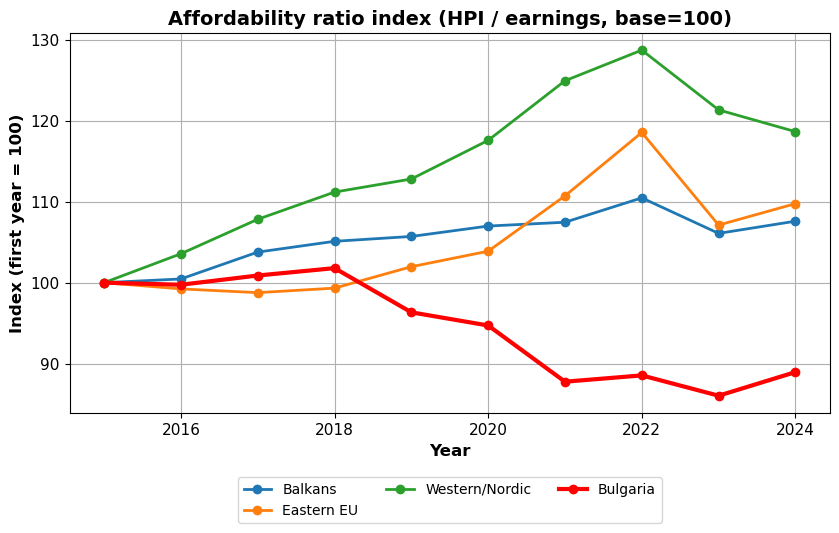

In [ ]:
fig, ax = plt.subplots(figsize=(8.5,5.5))

for reg, d in region_ts.groupby("region"):
    if reg != "Other":
        ax.plot(
            d["year"], d["avg_value"],
            marker="o", linewidth=2, label=reg
        )

bg = panel[panel["country"] == "Bulgaria"]
ax.plot(
    bg["year"], bg["afford_ratio_index"],
    color="red", marker="o", linewidth=3,
    label="Bulgaria"
)

ax.set_title("Affordability ratio index (HPI / earnings, base=100)", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=12, fontweight="bold")
ax.set_ylabel("Index (first year = 100)", fontsize=12, fontweight="bold")
ax.tick_params(labelsize=11)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.savefig(FIGS / "regions_afford_ratio_index_with_bg.png", dpi=160, bbox_inches="tight")
plt.show()


## 7) Save outputs

- time series with ratios  
- EU vs Bulgaria comparison  
- cluster labels


In [12]:
out_ts = PROC / "affordability_timeseries.csv"
out_bg_eu = PROC / "bg_vs_eu_affordability.csv"
out_clusters = PROC / "affordability_clusters.csv"

panel[[
    "country","year","afford_ratio","afford_ratio_real",
    "afford_ratio_index","afford_ratio_real_index"
]].to_csv(out_ts, index=False)

bg_eu_merged = bg_aff.merge(eu_aff, on="year", how="inner")
bg_eu_merged.to_csv(out_bg_eu, index=False)

labels.rename("cluster").to_frame().reset_index().to_csv(out_clusters, index=False)

out_ts, out_bg_eu, out_clusters


(WindowsPath('../data/processed/affordability_timeseries.csv'),
 WindowsPath('../data/processed/bg_vs_eu_affordability.csv'),
 WindowsPath('../data/processed/affordability_clusters.csv'))

# Affordability Analysis — Notes for the report

### HPI-to-earnings ratio (proxy for affordability)
- Constructed as **HPI / net_earnings**, normalized to 100 in the first available year for each country.  
- **EU27 mean** shows a steady deterioration of affordability: **+12% between 2015–2024**.  
- **Bulgaria**, in contrast, shows a **declining ratio: about –11%** over the same period, meaning housing affordability improved relative to earnings.  

---

### Bulgaria vs EU average
- Bulgaria’s affordability ratio index dropped from **~100 (2015) → ~89 (2024)**.  
- EU average rose to **~112 in 2024**.  
- This signals that **Bulgarian wage growth outpaced house price increases**, opposite to most of Europe.  

---

### Regional clustering
- Using heuristic grouping (Balkans, Eastern EU, Western/Nordic):  
  - **Western/Nordic:** strongest deterioration in affordability (**+18% by 2024**).  
  - **Eastern EU:** deterioration too, but with a **peak in 2022** and partial correction by 2024.  
  - **Balkans (Bulgaria, Croatia, Romania, etc):** much milder increase.  
- **Bulgaria stands out even within the Balkans**, showing a unique trajectory of *improving affordability*, while peers mostly worsened.  

---

### Clustering results
- **KMeans clustering** of affordability trajectories grouped Bulgaria with Southern/heterogeneous peers (e.g., Cyprus, Italy, Finland).  
- This reflects **statistical similarity in time-series shapes**, not strict geography.  
- **Regional grouping (by hand)** yields more interpretable patterns:  
  - **East vs West vs Balkans dynamics**, where Bulgaria is an outlier with improved affordability.


**Saved figures**
- `reports/figures/bg_vs_eu_afford_ratio_index.png`
- `reports/figures/clusters_afford_ratio_index.png`
- `reports/figures/regions_afford_ratio_index.png`

**Saved tables**
- `data/processed/affordability_timeseries.csv`
- `data/processed/bg_vs_eu_affordability.csv`
- `data/processed/affordability_clusters.csv`
